# Ranking Ads (Multi Armed Bandit)
### Proyecto Final Metodos Analiticos 2018
#### Daniel Camarena (109417), Maximiliano Alvarez

#### Introduccion

Este proyecto tiene como intencion, aplicar diferentes politicas dentro del algoritmo de *multi armed bandits* para elegir el mejor anuncio a mostrar (en una pagina web) dado un *pool* de anuncios donde unicamente contaremos con la informacion historica (numero de clicks) de cada anuncio. El objetivo de cada una de las politicas implementadas sera mostrar el auncio que generara mayor numero de clicks cada vez que es mostrado.

En este trabajo compararemos el desempeño de algunas politicas implementadas dentro del algoritmo *multi armed bandits* en diferentes situaciones asumiendo siempre que cada anuncio tiene una probabilidad inherente de ser seleccionado cada vez que es mostrado (esta probabilidad no es conocida por el agente) y cambiaremos las condiciones del ambiente durante la comparacion del desempeño (mismo pago vs pago diferente cada click, pocos anuncios vs muchos anuncios, anuncios permantentes vs anuncios que vencen, probabilidad de eleccion fija vs probabilidad de eleccion cambiante)

### 1. Algoritmos mas comunes

Hablar un poco sobre UCB, Epsilon Greedy, Softmax, Sampleo Thompson


#### Epsilon Greedy

A continuación presentaremos la implementación del algoritmo *Epsilon Greedy* y su desempeño con diferentes *epsilon* (0.1,0.2,0.3,0.4,0.5) en un ambiente simulado de máquinas Bernoulli.

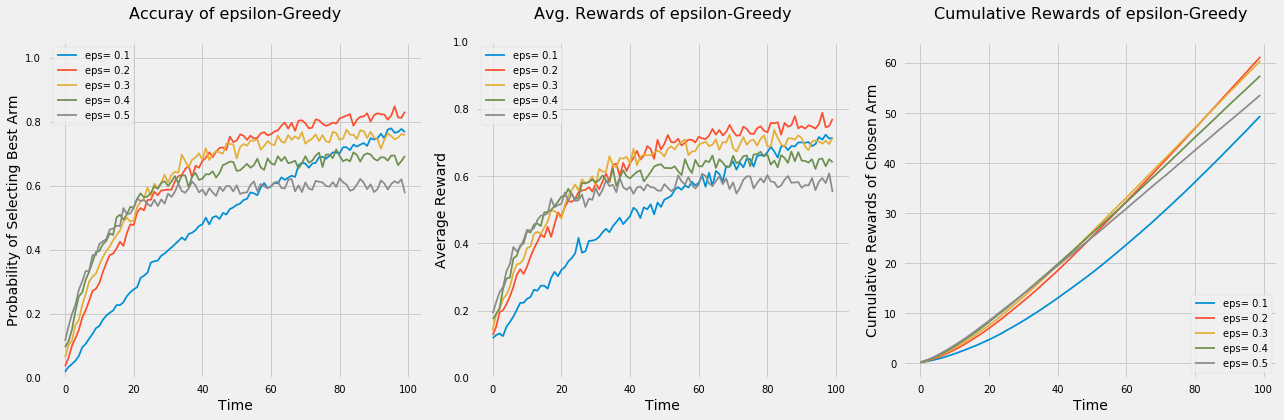

In [8]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

class EpsilonGreedy:
    def __init__(self, epsilon, counts=None, values=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms,dtype=int)
        self.values = np.zeros(n_arms,dtype=float)

    def select_arm(self):
        z = np.random.random()
        if z > self.epsilon:
            return np.argmax(self.values)
        return np.random.randint(0, len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = value * ((n-1)/n) + reward/n
        self.values[chosen_arm]=new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "epsilon-Greedy": EpsilonGreedy
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    for hyper_param in hyper_params:
        algo = ALGORITHMS[alg_name](hyper_param)
        chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
        axes[0].plot(average_probs, label=label + "= %s" %hyper_param)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
        axes[0].legend()
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards, label=label + "= %s" %hyper_param)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[1].legend()
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards, label=label + "= %s" %hyper_param)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[2].legend(loc="lower right")
        plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=1000, horizon=100, label="eps")


#### UCB

A continuación se presenta la implementación del algoritmo *UCB* y su desempeño en un ambiente simulado de maquinas Bernoulli

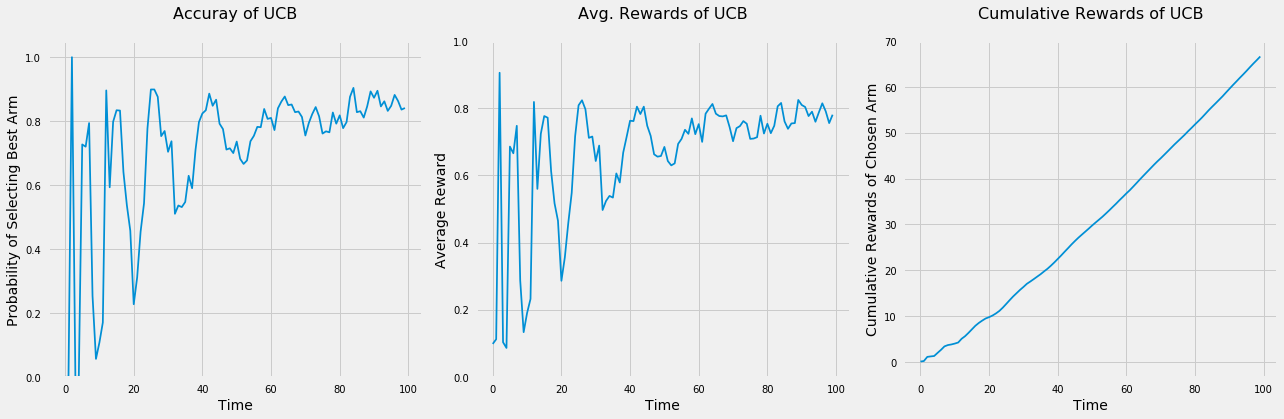

In [9]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")


class UCB:
    def __init__(self, counts=None, values=None):
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        n_arms = len(self.counts)

        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm

        ucb_values = np.zeros(n_arms)
        n = np.sum(self.counts)
        for arm in range(n_arms):
            bonus = np.sqrt((2 * np.log(n)) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + bonus

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "UCB": UCB,
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    algo = ALGORITHMS[alg_name]()
    chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
    average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    axes[0].plot(average_probs)
    axes[0].set_xlabel("Time", fontsize=14)
    axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
    axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
    axes[0].set_ylim([0, 1.05])
    axes[1].plot(average_rewards)
    axes[1].set_xlabel("Time", fontsize=14)
    axes[1].set_ylabel("Average Reward", fontsize=14)
    axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
    axes[1].set_ylim([0, 1.0])
    axes[2].plot(cum_rewards)
    axes[2].set_xlabel("Time", fontsize=14)
    axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
    axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
    plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
plot_algorithm(alg_name="UCB", arms=arms, best_arm_index=best_arm_index, num_simulations=1000, horizon=100)


#### Softmax

A continuación presentaremos la implementación del algoritmo *Softmax* y su desempeño con diferentes *temperaturas* (0.1,0.2,0.3,0.4,0.5) en un ambiente simulado de máquinas Bernoulli.

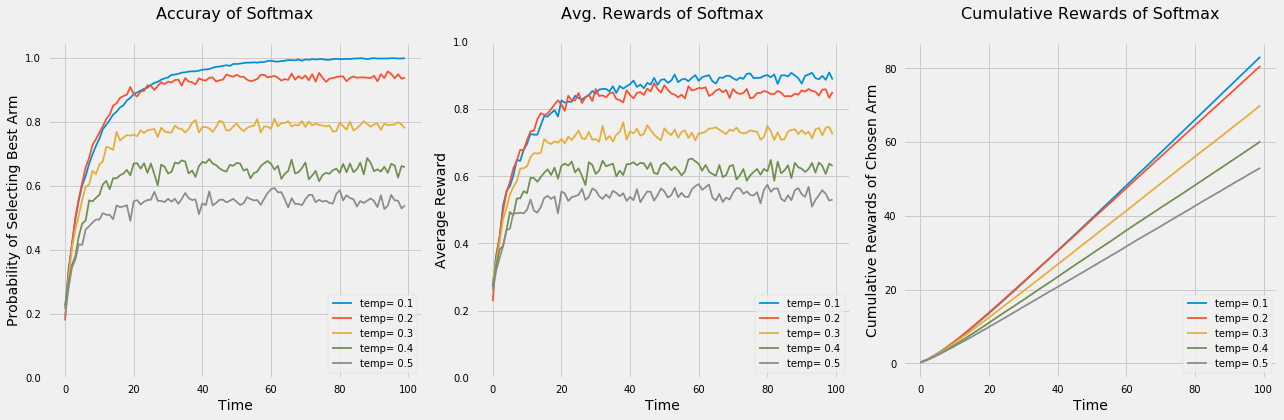

In [10]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")


class Softmax:
    def __init__(self, temperature, counts=None, values=None):
        self.temperature = temperature
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        z = self.values / self.temperature
        probs = np.exp(z) / np.sum(np.exp(z))
        return Softmax.categorical_draw(probs)

    @staticmethod
    def categorical_draw(probs):
        preds = np.random.multinomial(1, probs, 1)
        return np.argmax(preds)

    def update(self, chosen_arm, reward):
        # Increment counts
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Update the expected values of chosen arm
        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "Softmax": Softmax,
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    for hyper_param in hyper_params:
        algo = ALGORITHMS[alg_name](hyper_param)
        chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
        axes[0].plot(average_probs, label=label + "= %s" %hyper_param)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
        axes[0].legend()
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards, label=label + "= %s" %hyper_param)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[1].legend()
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards, label=label + "= %s" %hyper_param)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[2].legend(loc="lower right")
        plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
temperature = [0.1, 0.2, 0.3, 0.4, 0.5]
plot_algorithm(alg_name="Softmax", arms=arms, best_arm_index=best_arm_index,
               hyper_params=temperature, num_simulations=1000, horizon=100, label="temp")


#### 1.1 Configuracion Clasica

Con el fin de comparar diferentes politicas, empezaremos con la formulacion mas comun de este problema, descrita a continuacion: 

+ En cada paso un anuncio tiene que ser elegido para ser mostrado dentro de un pool de anuncios
+ Cada anuncio tiene una probabilidad de ser *clickeado* cuando es mostrado, esta probabilidad es constante en el tiempo
+ Cada vez que un anuncio es mostrado, se conoce si fue *clickeado* o no.
+ No hay diferencia entre los *clicks* otorgados por el usuario: i.e. la recompensa es igual siempre

El ambiente de simulación se configurará como sigue:

+ Probabilidad de cada anuncio para recibir un click (Pclick_ad~Beta(2,17))
+ 100,000 iteraciones en el tiempo
+ Cuando aplique, la probabilidad inicial de recibir un click será del 50%

/Users/ocamarena/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


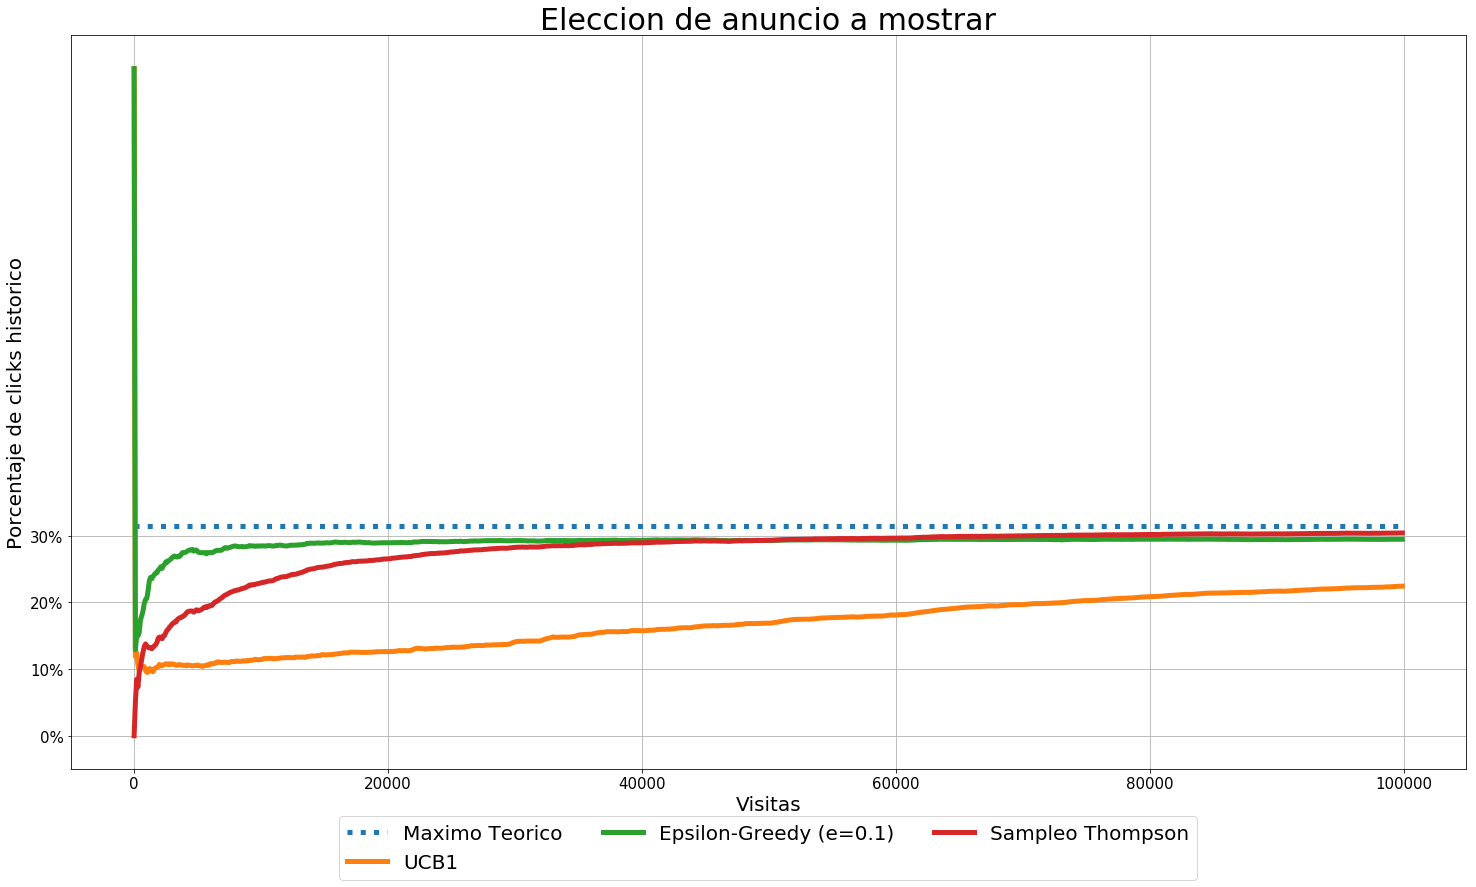

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

# Creamos 100 anuncios
n_ads=100
np.random.seed(159)
ads_clickprob=np.random.beta(2,17,size=n_ads)
max_ctr=np.max(ads_clickprob)

# Contadores para cada algoritmo
clicks_eg1=np.array([1]*n_ads)
trials_eg1=np.array([2]*n_ads)
ctr_eg1 = list()

clicks_ucb1=np.array([1]*n_ads)
trials_ucb1=np.array([2]*n_ads)
ctr_ucb1=list()

clicks_thomp=np.array([0]*n_ads)
trials_thomp=np.array([0]*n_ads)
ctr_thomp=list()

# Iniciamos simulacion

np.random.seed(123)
for i in range(100000):
    if np.random.random()<=0.1: #Estamos considerando una epsilon de 0.1
        ad_eg1=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg1=np.argmax(clicks_eg1/trials_eg1)
    trials_eg1[ad_eg1]+=1
    
    ad_ucb1=np.argmax(clicks_ucb1/trials_ucb1 + np.sqrt(2*np.log(i+3))/np.sqrt(trials_ucb1))
    trials_ucb1[ad_ucb1]+=1
    
    ad_thompson=np.argmax([np.random.beta(clicks_thomp[a]+1,trials_thomp[a]-clicks_thomp[a]+1) for a in range(n_ads)])
    trials_thomp[ad_thompson]+=1
    
    # Determinando los anuncios con clicks
    would_have_clicked=[np.random.binomial(1,ads_clickprob[a]) for a in range(n_ads)]
    
    clicks_eg1[ad_eg1]+=would_have_clicked[ad_eg1]
    clicks_ucb1[ad_ucb1]+=would_have_clicked[ad_ucb1]
    clicks_thomp[ad_thompson]+=would_have_clicked[ad_thompson]
    
    # Revisando el CTR de cada algoritmos cada 100 iteraciones
    if (i%100)==0:
        ctr_eg1.append((np.sum(clicks_eg1)-1*n_ads)/(np.sum(trials_eg1)-2*n_ads))
        ctr_ucb1.append((np.sum(clicks_ucb1)-1*n_ads)/(np.sum(trials_ucb1)-2*n_ads))
        ctr_thomp.append(np.sum(clicks_thomp)/np.sum(trials_thomp))
        

# Visualizando resultados
rcParams['figure.figsize'] = 25, 15
lwd=5
plt.plot([np.max(ads_clickprob)]*int((i+1)/100),linestyle=':',label='Maximo Teorico',linewidth=lwd)
plt.plot(ctr_ucb1,label='UCB1',linewidth=lwd)
plt.plot(ctr_eg1,label='Epsilon-Greedy (e=0.1)',linewidth=lwd)
plt.plot(ctr_thomp,label='Sampleo Thompson',linewidth=lwd)
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})
plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,1000+200,200)])
ax.yaxis.set_ticks([i/10 for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])
ax.yaxis.set_ticklabels([str(i*10)+'%' for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])

plt.xlabel('Visitas',size=20)
plt.ylabel('Porcentaje de clicks historico',size=20)
plt.title('Eleccion de anuncio a mostrar',size=30)
plt.show()
    
    

#### Conclusiones sobre el ejercicio

Concluir un poco sobre las graficas presentadas anteriormente
